# The unusual 3D distrubution of NaCl around the AGB star IK Tau
---

_Based on the work by [Coenegrachts et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023arXiv230206221C/abstract)._

In [32]:
import matplotlib.pyplot as plt
import numpy             as np
import torch

from torch.optim            import Adam
from tqdm                   import tqdm
from astropy                import units, constants
from ipywidgets             import interact

from pomme.utils         import convert_angular_to_spatial
from pomme.plot          import plot_cube_2D, plot_spectrum
from pomme.object        import AstroObject
from pomme.observation   import DataCube, Beam
from pomme.model         import TensorModel
from pomme.utils         import print_var, interpolate, convert_angular_to_spatial, planck, T_CMB
from pomme.lines         import Line
from pomme.loss          import Loss, SphericalLoss, diff_loss 
from pomme.hydrodynamics import Hydrodynamics

In [2]:
# Extract object data from Simbad
obj = AstroObject('IK Tau')

Using the parallax distance.


In [3]:
# Extract line data from file
line = Line('NaCl', 25, datafile='data/23Na-35Cl__Barton-ExoMol.dat')

You have selected line:
    NaCl(J=26 0-25 0)
Please check the properties that were inferred:
    Frequency         3.380198940e+11  Hz
    Einstein A coeff  1.859200000e-02  1/s
    Molar mass        58.44276928000001  g/mol


In [4]:
# Extract continuum data from file
dat_cont = DataCube('/enif-pool/taissa/ALMA/IKTau/IK_Tau.continuum_ap1.fits')

In [5]:
dat_cont.plot_channel_maps()

interactive(children=(IntSlider(value=0, description='f', max=0), Output()), _dom_classes=('widget-interact',)…

<function pomme.observation.DataCube.plot_channel_maps.<locals>.plot(f)>

In [6]:
# Find location of the star by taking the average position, weighted by the 49 brightest pixels
ix, iy = np.meshgrid(np.arange(dat_cont.img.shape[1]), np.arange(dat_cont.img.shape[2]))

dist = dat_cont.img - dat_cont.img.min() 
dist[dist<np.sort(dist.ravel())[-49]] = 0.0
dist *= 1.0 / np.sum(dist)

idx_star = np.sum(iy * dist)
idy_star = np.sum(ix * dist)

In [7]:
# Extract line data from file
dat = DataCube('/STER/frederikd/Deprojection/data/observations/IKTau_NaCl26-25.fits')

In [8]:
dat.plot_channel_maps()

interactive(children=(IntSlider(value=37, description='f', max=75), Output()), _dom_classes=('widget-interact'…

<function pomme.observation.DataCube.plot_channel_maps.<locals>.plot(f)>

In [9]:
dat.plot_spectrum()

interactive(children=(IntSlider(value=127, description='i', max=255), IntSlider(value=127, description='j', ma…

<function pomme.observation.DataCube.plot_spectrum.<locals>.plot(i, j)>

In [10]:
# Crop the observations 
fi_min, fi_max =  30,  55
xi_min, xi_max = 115, 150
yi_min, yi_max = 110, 145

obs_data = dat.img[fi_min:fi_max, xi_min:xi_max, yi_min:yi_max]
obs_freq = dat.fs [fi_min:fi_max]
obs_xlim = dat.xs [xi_max] - dat.xs[xi_min]
obs_ylim = dat.xs [xi_max] - dat.xs[xi_min]
obs_cont = dat_cont.img[0, xi_min:xi_max, yi_min:yi_max]

# Get the location of the star in cropped indices
idx_star -= xi_min
idy_star -= yi_min

In [11]:
obs_freq.shape

(25,)

In [12]:
obs_freq.min().value

337960718839.5296

In [13]:
obs_freq.max().value

338007591235.81964

In [14]:
s_x = abs(convert_angular_to_spatial(obs_xlim, obj.distance)).si.value
s_y = abs(convert_angular_to_spatial(obs_ylim, obj.distance)).si.value
s_z = np.mean([s_x, s_y])

In [15]:
def plot(f):
    plt.figure(dpi=150)
    plt.imshow(obs_data[f,:,:], vmin=obs_data.min(), vmax=obs_data.max())
    plt.contour(obs_cont, colors='w', levels=np.array([0.1, 0.5, 0.8])*obs_cont.max())
    plt.scatter([idy_star], [idx_star], c='w', marker='*') # switch x and y, to conform to imshow convention
interact(plot, f=(0, obs_data.shape[0]-1))

interactive(children=(IntSlider(value=12, description='f', max=24), Output()), _dom_classes=('widget-interact'…

<function __main__.plot(f)>

In [16]:
# Extract beam from the observation
beam = Beam(dat)

# Convolve observation with beam
bmd_data = np.empty_like(obs_data)
for f in range(obs_data.shape[0]):
    bmd_data[f,:,:] = beam.apply(obs_data[f,:,:])

def plot(f):
    fig, axs = plt.subplots(1, 2, dpi=150)
    axs[0].set_title('Original')
    axs[1].set_title('Convolved with beam')
    axs[0].add_artist(beam.object.ellipse_to_plot(3, 31, dat.pixsize_x)).set_color('w')
    axs[1].add_artist(beam.object.ellipse_to_plot(3, 31, dat.pixsize_x)).set_color('w')
    axs[0].imshow(obs_data[f,:,:] , vmin=obs_data.min(), vmax=obs_data.max())
    axs[1].imshow(bmd_data[f,:,:],  vmin=bmd_data.min(), vmax=bmd_data.max())
    axs[0].scatter([idy_star], [idx_star], c='y', marker='*') # switch x and y, to conform to imshow convention
    axs[1].scatter([idy_star], [idx_star], c='y', marker='*') # switch x and y, to conform to imshow convention
interact(plot, f=(0, obs_data.shape[0]-1))

interactive(children=(IntSlider(value=12, description='f', max=24), Output()), _dom_classes=('widget-interact'…

<function __main__.plot(f)>

In [17]:
# Move frequency axis last
obs   = np.moveaxis(bmd_data, 0, -1)

# Store the observations and frequencies (in 64 bit precision)
obs   = torch.from_numpy(obs     .astype(np.float64))
freqs = torch.from_numpy(obs_freq.astype(np.float64).si.value)

In [18]:
# Fixed parameters
v_trb = 1.50e+2
v_max = 2.84e+4 / 50
v_los = 34000.0 #obj.radial_velocity.si.value

R_star = 3.8e11   # [m]
T_star = 2100.0   # [K]

In [19]:
rs = np.linspace(R_star, (210*units.au).si.value, 1000)

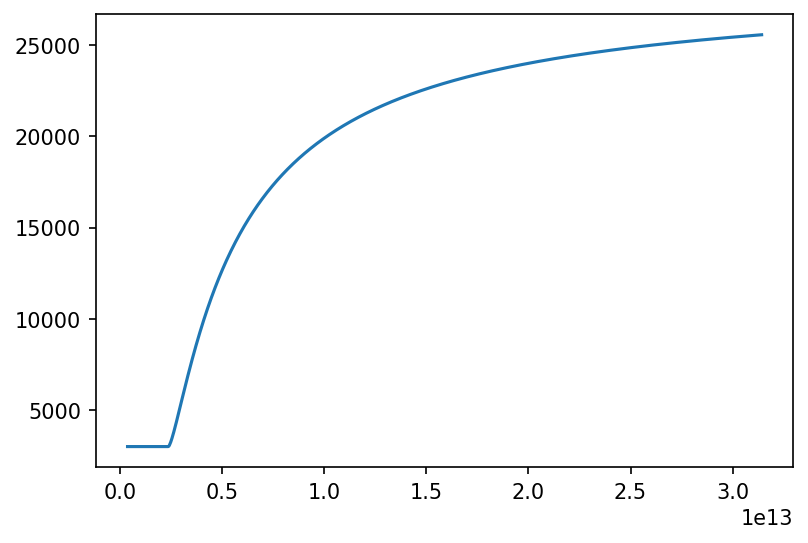

In [20]:
def beta_velocity(r):
    v_0    = 3.00e+3   # m/s
    v_exp  = 2.84e+4   # m/s
    r_dust = 2.38e12   # m
    beta   = 1.5       #
    v_beta = np.empty_like(r)
    v_beta[r> r_dust] = v_0 + (v_exp - v_0) * (1.0 - r_dust/r[r>r_dust])**beta
    v_beta[r<=r_dust] = v_0
    return v_beta

plt.figure(dpi=150)
plt.plot(rs, beta_velocity(rs))

In [21]:
r_temp, T_temp = np.loadtxt('iktau-co-04-grid-38.temp', unpack=True)
r_temp *= 1.0e-2 # [cm] -> [m]

r_temp = np.concatenate(([R_star], r_temp))
T_temp = np.concatenate(([T_star], T_temp))

from scipy.interpolate import interp1d

temperature_func = interp1d(r_temp, T_temp, fill_value='extrapolate')

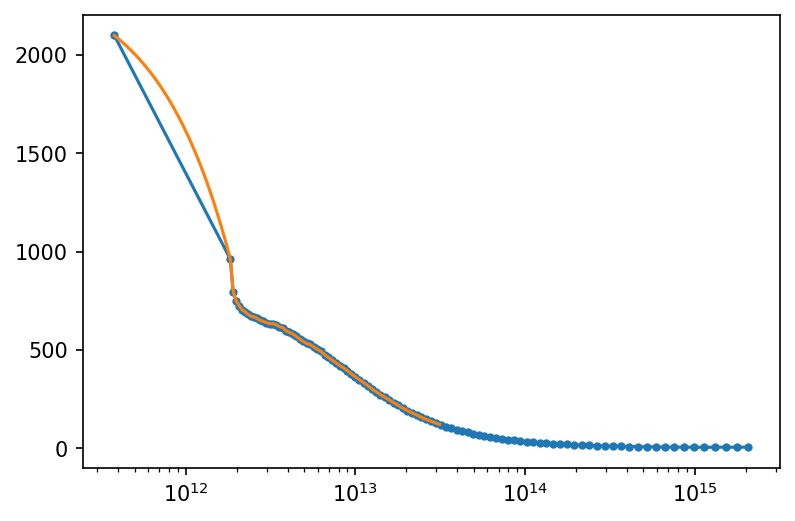

In [22]:
plt.figure(dpi=150)
plt.plot(r_temp, T_temp, marker='.')
plt.plot(rs, temperature_func(rs))
plt.xscale('log')

In [23]:
model = TensorModel(
    sizes = (s_x, s_y, s_z),
    shape = (obs.shape[0], obs.shape[1], 64),
)

origin        = np.array([idx_star, idy_star, 0.5*model.shape[2]])
r_x, r_y, r_z = model.get_radial_direction(origin=origin)
p_x, p_y, p_z = model.get_coords          (origin=origin)
r             = model.get_radius          (origin=origin)
inverse_r     = r.min() / r

# Define and initialize the model parameters
# model['log_M'           ] = np.log(constants.M_sun.si.value)
model['log_NaCl'        ] = np.log(1.0e+10 * inverse_r**2)
model['log_temperature' ] = np.log(temperature_func(r))
model['velocity_x:v_max'] = r_x * beta_velocity(r) / v_max
model['velocity_y:v_max'] = r_y * beta_velocity(r) / v_max
model['velocity_z:v_max'] = r_z * beta_velocity(r) / v_max
# model['log_v_los'       ] = np.log(v_los.si.value)

model.free_all()
model.fix('log_temperature')
model.fix(['velocity_x:v_max'])
model.fix(['velocity_y:v_max'])
model.fix(['velocity_z:v_max'])
# model.fix('log_v_turbulence')
# model.fix('log_v_los')

model.info()

Variable key:              Free/Fixed:   Field:    Min:           Mean:          Max:
  log_NaCl                   Free          True     +1.473e+01     +1.612e+01     +2.303e+01
  log_temperature            Fixed         True     +4.289e+00     +5.022e+00     +7.480e+00
  velocity_x:v_max           Fixed         True     -4.446e+01     -2.317e+00     +4.369e+01
  velocity_y:v_max           Fixed         True     -4.510e+01     -7.153e+00     +4.264e+01
  velocity_z:v_max           Fixed         True     -4.427e+01     -5.583e-01     +4.408e+01
sizes: (54603456820797.37, 54603456820797.37, 54603456820797.37)
shape: (35, 35, 64)


In [24]:
r.min() * units.m.to(units.au)

5.343744142025458

In [25]:
r.min() / (1.0 * units.au).si.value

5.343744142025458

In [26]:
# M = torch.exp(model['log_M'])

# hydrodynamics = Hydrodynamics(
#     gamma  = 1.2,
#     mu     = 2.381 * constants.u.si.value,
#     f_x    = -constants.G.si.value * M * r_x / r**2,
#     f_y    = -constants.G.si.value * M * r_y / r**2,
#     f_z    = -constants.G.si.value * M * r_z / r**2,
#     Lambda = 0.0
# )

spherical_loss = SphericalLoss(
    model  = model,
    origin = origin
)

# loss = Loss(['rep', 'reg', 'sym'] + list(hydrodynamics.loss_keys.values()))
# loss = Loss(['rep', 'reg', 'sym'])
# loss = Loss(['rep', 'reg', 'ext'])
loss = Loss(['rep', 'reg'])
# loss = Loss(['rep'])

In [29]:
def forward(model, freqs):
    """
    Forward model: image the given TensorModel along the last axis, 
    at the given frequencies, assuming local thermodynamical equilibrium (LTE).
    """
    Ibdy  = torch.ones((model.shape[0], model.shape[1], len(freqs)), dtype=torch.float64)
    Ibdy *= planck(temperature=T_CMB, frequency=freqs)

    img = line.LTE_image_along_last_axis(
        abundance    = torch.exp(model['log_NaCl']),
        temperature  = torch.exp(model['log_temperature']),
        v_turbulence = v_trb,
        velocity_los = v_los + v_max * model['velocity_z:v_max'],
        frequencies  = freqs,
        dx           = model.dx(model.dim()-1),
        img_bdy      = planck(temperature=T_CMB, frequency=freqs)
    )

    # Avoid negative values (should probably avoid these earlier...)
    img = torch.abs(img)

    # Convert to Jy/pixel
    img *= model.dx(0) * model.dx(1) / obj.distance.si.value**2 / 1.0e-26
    
    # Convolve with beam (i.e. convert to Jy/beam)
    img = beam.torch_apply(img)

    return img

In [33]:
img = forward (model, freqs)

def plot(i,j):
    plt.figure(dpi=150)
    plt.plot   (line.freq_to_velo(freqs          * units.Hz), obs[i,j,:].data)
    plt.plot   (line.freq_to_velo(freqs          * units.Hz), img[i,j,:].data, marker='x')
    plt.axvline(line.freq_to_velo(line.frequency * units.Hz) - v_los, c='k')
interact(plot, i=(0, img.shape[0]-1), j=(0, img.shape[1]-1) )

interactive(children=(IntSlider(value=17, description='i', max=34), IntSlider(value=17, description='j', max=3…

<function __main__.plot(i, j)>

In [34]:
img.min()

tensor(1.8620e-06, grad_fn=<MinBackward1>)

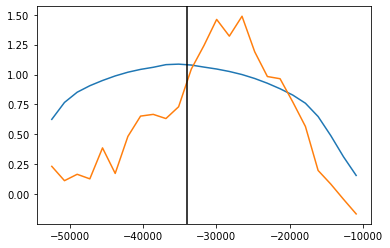

In [35]:
plt.plot(line.freq_to_velo(freqs * units.Hz), img.sum(dim=(0,1)).data/30)
plt.plot(line.freq_to_velo(freqs * units.Hz), obs.sum(dim=(0,1)).data)
plt.axvline(line.freq_to_velo(line.frequency * units.Hz) - v_los, c='k')

In [36]:
def fit(loss, model, data, N_epochs=10, lr=1.0e-1):

    optimizer = Adam(model.free_parameters(), lr=lr)

    for _ in tqdm(range(N_epochs)):
        
        # Run forward model
        img = forward(model, freqs)
 
        # Reproduction loss between model image and observations
        loss['rep'] = torch.nn.functional.mse_loss(img, obs)

        # Regularisation loss
        loss['reg'] = diff_loss(model['log_NaCl']) #model.apply_to_fields(diff_loss)
        
        # loss['ext'] = torch.mean(torch.exp(model['log_NaCl'])) #+ torch.mean(torch.exp(model['log_temperature']))

        # Spherical symmetry loss
        # loss['sym'] = model.apply_to_fields(
            # func    = spherical_loss.eval,
            # exclude = ['velocity_x/v_max', 'velocity_y/v_max', 'velocity_z/v_max'],
            # include = [model['velocity_x/v_max']**2 + model['velocity_y/v_max']**2 + model['velocity_z/v_max']**2]
        # )

        # loss = hydrodynamics.add_steady_state_loss(
        #     model   = model,
        #     loss    = loss,
        #     log_rho = model['log_CO'],
        #     log_tmo = model['log_temperature'],
        #     v_x     = v_max * model['velocity_x/v_max'],
        #     v_y     = v_max * model['velocity_y/v_max'],
        #     v_z     = v_max * model['velocity_z/v_max'],
        # )
        
        # Set gradients to zero
        optimizer.zero_grad()
        # Backpropagate gradients
        loss.tot().backward()
        # Update parameters
        optimizer.step()

  0%|          | 0/5 [00:00<?, ?it/s]/home/frederikd/.local/lib/python3.9/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 5/5 [00:01<00:00,  3.45it/s]


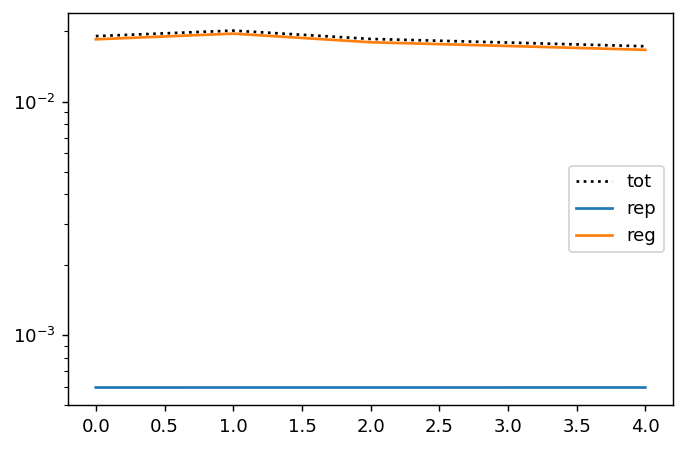

In [37]:
fit(loss, model, obs, N_epochs=5, lr=1.0e-1)
loss.plot()

In [38]:
loss.renormalise_all()
loss.reset()

100%|██████████| 5/5 [00:01<00:00,  3.66it/s]


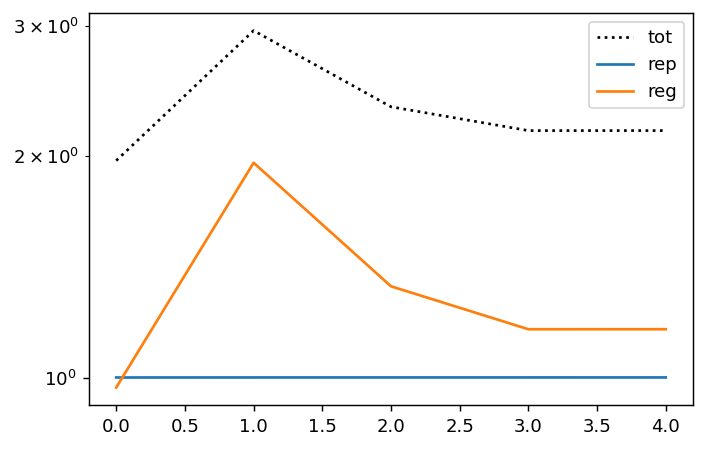

In [39]:
fit(loss, model, obs, N_epochs=5, lr=1.0e-1)
loss.plot()

In [40]:
loss.weight['rep'] *= 1.0e+2
loss.weight['reg'] *= 1.0e+0
# loss.weight['ext'] *= 1.0e+1

In [54]:
img = forward (model, freqs)

In [55]:
def plot(i,j):
    plt.figure(dpi=150)
    plt.plot   (line.freq_to_velo(freqs          * units.Hz), obs[i,j,:].data)
    plt.plot   (line.freq_to_velo(freqs          * units.Hz), img[i,j,:].data, marker='x')
    plt.axvline(line.freq_to_velo(line.frequency * units.Hz) - v_los, c='k')
interact(plot, i=(0, img.shape[0]-1), j=(0, img.shape[1]-1) )

interactive(children=(IntSlider(value=17, description='i', max=34), IntSlider(value=17, description='j', max=3…

<function __main__.plot(i, j)>

In [56]:
v_los

34000.0

In [57]:
def plot(f):
    fig, axs = plt.subplots(1, 2, dpi=150)
    axs[0].set_title('Observation')
    axs[1].set_title('Model')
    axs[0].imshow(obs[:,:,f].data, vmin=obs.data.min(), vmax=obs.data.max())
    axs[1].imshow(img[:,:,f].data, vmin=img.data.min(), vmax=img.data.max())
    print((line.freq_to_velo(freqs[f] * units.Hz) + v_los)/1000)
interact(plot, f=(0, img.shape[2]-1))

interactive(children=(IntSlider(value=12, description='f', max=24), Output()), _dom_classes=('widget-interact'…

<function __main__.plot(f)>

In [45]:
plot_cube_2D(model['log_NaCl'])

interactive(children=(IntSlider(value=31, description='z', max=63), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [46]:
plot_cube_2D(model['log_temperature'])

interactive(children=(IntSlider(value=31, description='z', max=63), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [47]:
plot_cube_2D(model['velocity_z:v_max'])

interactive(children=(IntSlider(value=31, description='z', max=63), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [48]:
plot_spectrum(model['log_NaCl'])

interactive(children=(IntSlider(value=17, description='i', max=34), IntSlider(value=17, description='j', max=3…

<function pomme.plot.plot_spectrum.<locals>.plot(i, j)>

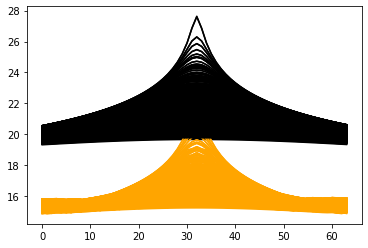

In [49]:
initial = np.log(1.0e+12 * inverse_r**2)
result  = model['log_NaCl'].data
for i in range(model.shape[0]):
    for j in range(model.shape[1]):
        plt.plot(result [i,j], c='orange')
        plt.plot(initial[i,j], c='black')

In [50]:
np.exp(12)

162754.79141900392

100%|██████████| 250/250 [00:59<00:00,  4.21it/s]


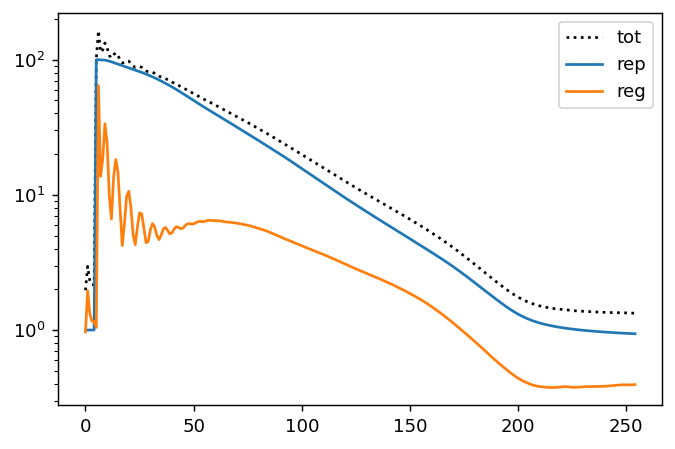

In [51]:
fit(loss, model, obs, N_epochs=250, lr=5.0e-1)
loss.plot()

In [52]:
loss.weight['rep'] *= 1.0e+2
loss.weight['reg'] *= 1.0e+0
# loss.weight['ext'] *= 1.0e+2

100%|██████████| 250/250 [00:57<00:00,  4.38it/s]


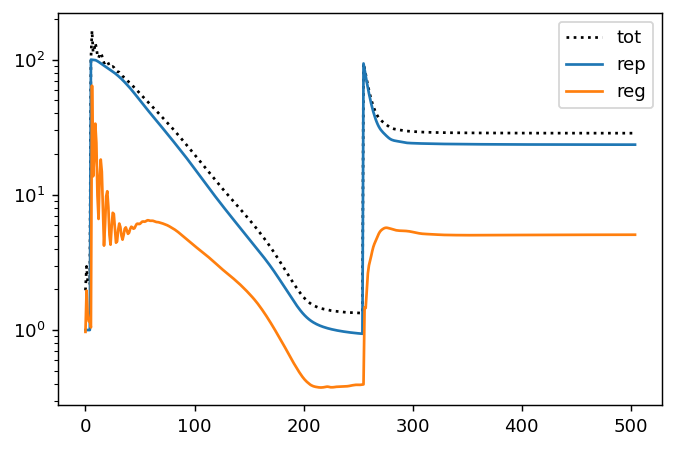

In [53]:
fit(loss, model, obs, N_epochs=250, lr=1.0e-1)
loss.plot()

In [49]:
model.save('IK_Tau.h5')

In [4]:
model = TensorModel.load('IK_Tau.h5')

rho = torch.exp(model['log_NaCl']).data.numpy().astype(np.float32)


In [7]:

from pomme.model import TensorModel
import k3d

model = TensorModel.load('IK_Tau.h5')

rho = torch.exp(model['log_NaCl']).data.numpy().astype(np.float32)



# star_location = (origin/rho.shape-0.5).astype(np.float32)
# star_radius   = R_star/np.mean(model.sizes)

plt_volume = k3d.volume(
    volume      = rho / 1.0e+6,
    alpha_coef  = 40.0,
    # color_range = [0, 5000000]
    color_range = [0, 5]
)
# plt_star   = k3d.points(
    # positions  = [star_location],
    # point_size = 3*star_radius,
    # color      = 0xffd600
# )

plot  = k3d.plot()
plot += plt_volume
# plot += plt_star
plot.display()

Output()

In [ ]:
from pomme.model import TensorModel
import k3d
import numpy as np

model = TensorModel.load('IK_Tau.h5')

rho = torch.exp(model['log_NaCl']).data.numpy().astype(np.float32)

plt_volume = k3d.volume(
    volume      = rho / 1.0e+6,
    alpha_coef  = 40.0,
    color_range = [0, 5]
)


plot  = k3d.plot()
plot += plt_volume
plot.display()

In [ ]:
fit(loss, model, obs, N_epochs=500, lr=1.0e-0)
loss.plot()

  4%|▍         | 21/500 [00:11<04:11,  1.91it/s]


KeyboardInterrupt: 

In [ ]:
model.save('IK_Tau.h5')

100%|██████████| 500/500 [03:58<00:00,  2.10it/s]


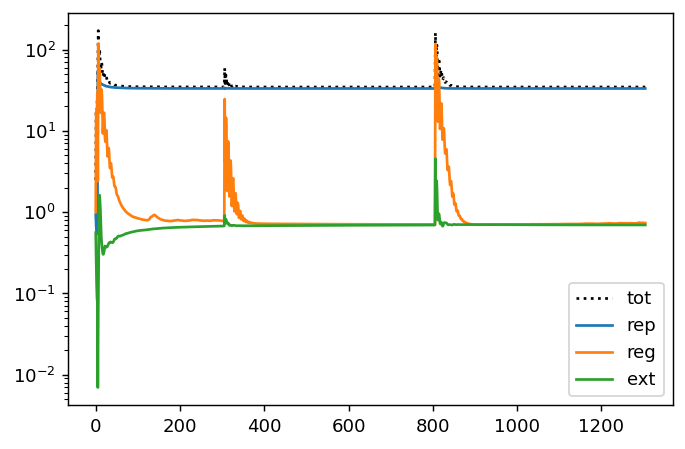

In [ ]:
fit(loss, model, obs, N_epochs=500, lr=3.0)
loss.plot()

In [9]:
model.info()

Variable key:              Free/Fixed:   Field:    Min:           Mean:          Max:
  log_NaCl                   Free          True     +7.515e+00     +8.655e+00     +1.594e+01
  log_temperature            Fixed         True     +4.289e+00     +5.022e+00     +7.480e+00
  velocity_x:v_max           Fixed         True     -4.446e+01     -2.317e+00     +4.369e+01
  velocity_y:v_max           Fixed         True     -4.510e+01     -7.153e+00     +4.264e+01
  velocity_z:v_max           Fixed         True     -4.427e+01     -5.583e-01     +4.408e+01
sizes: [5.46034568e+13 5.46034568e+13 5.46034568e+13]
shape: (35, 35, 64)


In [13]:
model['velocity_x:v_max']

tensor([[[-26.1762, -26.3974, -26.6172,  ..., -26.8351, -26.6172, -26.3974],
         [-26.6527, -26.8866, -27.1191,  ..., -27.3500, -27.1191, -26.8866],
         [-27.1308, -27.3779, -27.6239,  ..., -27.8684, -27.6239, -27.3779],
         ...,
         [-30.3453, -30.6951, -31.0458,  ..., -31.3970, -31.0458, -30.6951],
         [-29.9169, -30.2515, -30.5867,  ..., -30.9220, -30.5867, -30.2515],
         [-29.4731, -29.7925, -30.1122,  ..., -30.4316, -30.1122, -29.7925]],

        [[-25.1285, -25.3480, -25.5663,  ..., -25.7830, -25.5663, -25.3480],
         [-25.6016, -25.8341, -26.0656,  ..., -26.2956, -26.0656, -25.8341],
         [-26.0772, -26.3234, -26.5687,  ..., -26.8128, -26.5687, -26.3234],
         ...,
         [-29.3003, -29.6538, -30.0089,  ..., -30.3651, -30.0089, -29.6538],
         [-28.8681, -29.2056, -29.5442,  ..., -29.8835, -29.5442, -29.2056],
         [-28.4212, -28.7427, -29.0650,  ..., -29.3874, -29.0650, -28.7427]],

        [[-24.0308, -24.2476, -24.4634,  ...